In [10]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import os


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import acquire
import prepare

In [183]:
def prep_telco():
    telco_churn_db = acquire.get_telco_data()
    telco_churn_db = telco_churn_db.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'])
    dummy_telco_churn_db = pd.get_dummies(telco_churn_db[['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'internet_service_type', 'payment_type']], dummy_na=False, drop_first=True)
    telco_churn_db = pd.concat([telco_churn_db, dummy_telco_churn_db], axis=1)
    return telco_churn_db

In [184]:
t = acquire.get_telco_data()
t.shape

(7043, 25)

In [185]:
def prep_telco_alternative():
    telco_churn_db = acquire.get_telco_data()
    telco_churn_db = telco_churn_db.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'])
    dummy_telco_churn_db = pd.get_dummies(telco_churn_db[['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'internet_service_type', 'payment_type']], dummy_na=False, drop_first=True)
    #Since month-to-month seems VERY correlated to churn rate I am not dropping first when doing contract type specifically for knn nearest neighbors where I have to cut down the dimensions and choose the best correlated issues.  
    #I expect the decision trees to give me more intuition on the most highly correlated dimensions to choose
    dummy_telco_churn_db_first = pd.get_dummies(telco_churn_db[['contract_type']], dummy_na=False, drop_first=False) 
    telco_churn_db = pd.concat([telco_churn_db, dummy_telco_churn_db, dummy_telco_churn_db_first], axis=1)
    return telco_churn_db

In [186]:
def split_data(df, stratify_col):
    train_validate, test = train_test_split(df, test_size = .2, random_state=823, stratify=df[stratify_col])
    train, validate = train_test_split(train_validate, test_size=.25, random_state=823, stratify=train_validate[stratify_col])
    return train, validate, test

In [187]:
telco = prepare.prep_telco_alternative()
telco.dtypes

Unnamed: 0                                 int64
senior_citizen                             int64
tenure                                     int64
monthly_charges                          float64
gender_Male                                uint8
partner_Yes                                uint8
dependents_Yes                             uint8
phone_service_Yes                          uint8
multiple_lines_No phone service            uint8
multiple_lines_Yes                         uint8
online_security_No internet service        uint8
online_security_Yes                        uint8
online_backup_No internet service          uint8
online_backup_Yes                          uint8
device_protection_No internet service      uint8
device_protection_Yes                      uint8
tech_support_No internet service           uint8
tech_support_Yes                           uint8
streaming_tv_No internet service           uint8
streaming_tv_Yes                           uint8
streaming_movies_No 

In [188]:
telco = telco.drop(columns=telco.select_dtypes(exclude='number').columns)

In [189]:
telco.dtypes

Unnamed: 0                                 int64
senior_citizen                             int64
tenure                                     int64
monthly_charges                          float64
gender_Male                                uint8
partner_Yes                                uint8
dependents_Yes                             uint8
phone_service_Yes                          uint8
multiple_lines_No phone service            uint8
multiple_lines_Yes                         uint8
online_security_No internet service        uint8
online_security_Yes                        uint8
online_backup_No internet service          uint8
online_backup_Yes                          uint8
device_protection_No internet service      uint8
device_protection_Yes                      uint8
tech_support_No internet service           uint8
tech_support_Yes                           uint8
streaming_tv_No internet service           uint8
streaming_tv_Yes                           uint8
streaming_movies_No 

Generalized Null hypothesis (For each Column): "Column" is independant of the Churn rate
Generalized Alt hypothesis (For each Column): "Column" and Churn rate are dependant
\alpha < 0.01.  Higher alpha is justified because n is large and there are so many columns to choose from

In [190]:
telco.churn_Yes.value_counts()

0    5174
1    1869
Name: churn_Yes, dtype: int64

In [191]:
baseline = 1869/(1869+5174)
baseline

0.2653698707936959

In [192]:
for col in telco.columns:
    col = pd.crosstab(telco[col], telco.churn_Yes)
    print(col)
    col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
    print(f'(chi squared = {col_chi2}, p = {col_p}')
    print('___________________________________________________________')

churn_Yes   0  1
Unnamed: 0      
0           1  0
1           1  0
2           0  1
3           0  1
4           0  1
...        .. ..
7038        1  0
7039        0  1
7040        1  0
7041        1  0
7042        1  0

[7043 rows x 2 columns]
(chi squared = 7043.0, p = 0.49439767459438705
___________________________________________________________
churn_Yes          0     1
senior_citizen            
0               4508  1393
1                666   476
(chi squared = 159.42630036838742, p = 1.510066805092378e-36
___________________________________________________________
churn_Yes    0    1
tenure             
0           11    0
1          233  380
2          115  123
3          106   94
4           93   83
5           69   64
6           70   40
7           80   51
8           81   42
9           73   46
10          71   45
11          68   31
12          79   38
13          71   38
14          52   24
15          62   37
16          52   28
17          61   26
18          73   2

"Unnamed: 0", "gender_male", "phone_service_Yes", "multiple_lines_No phone service" all do not meet the p-value we set and thus we do not have sufficient evidence to reject the null hypothesis.  Therefore I am dropping them all from the analysis.  "Unnamed: 0" is just an id number so it makes sense that they are independant events...kinda goes without saying but a good sanity check.

In [193]:
telco = telco.drop(columns=['Unnamed: 0', 'gender_Male', 'phone_service_Yes', 'multiple_lines_No phone service'])

### 

### I am normaizing the tenure and monthly charges so as to optimize the knn predictions.  These should not have an adverse effect of trees random forests or the logistic regression models as the calc ulations are scaled accordingly.  In addition the logistic regression should be simplified as well.

In [194]:
telco['tenure_normalized'] = (telco.tenure - telco.tenure.min()) / (telco.tenure.max() - telco.tenure.min())

In [195]:
telco['monthly_charges_normalized'] = (telco.monthly_charges - telco.monthly_charges.min()) / (telco.monthly_charges.max() - telco.monthly_charges.min())

In [196]:
telco = telco.drop(columns=['tenure', 'monthly_charges'])

In [197]:
telco = telco.drop(columns=['online_backup_No internet service', 'device_protection_No internet service', 'tech_support_No internet service', 'streaming_tv_No internet service', 'streaming_movies_No internet service', 'online_security_No internet service'])

In [198]:
for col in telco.columns:
    col = pd.crosstab(telco[col], telco.churn_Yes)
    print(col)
    col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
    print(f'(chi squared = {col_chi2}, p = {col_p}')
    print('___________________________________________________________')

churn_Yes          0     1
senior_citizen            
0               4508  1393
1                666   476
(chi squared = 159.42630036838742, p = 1.510066805092378e-36
___________________________________________________________
churn_Yes       0     1
partner_Yes            
0            2441  1200
1            2733   669
(chi squared = 158.7333820309922, p = 2.1399113440759935e-36
___________________________________________________________
churn_Yes          0     1
dependents_Yes            
0               3390  1543
1               1784   326
(chi squared = 189.12924940423474, p = 4.9249216612154196e-43
___________________________________________________________
churn_Yes              0     1
multiple_lines_Yes            
0                   3053  1019
1                   2121   850
(chi squared = 11.143251001456251, p = 0.0008433795342472428
___________________________________________________________
churn_Yes               0     1
online_security_Yes            
0              

In [199]:
telco.shape

(7043, 22)

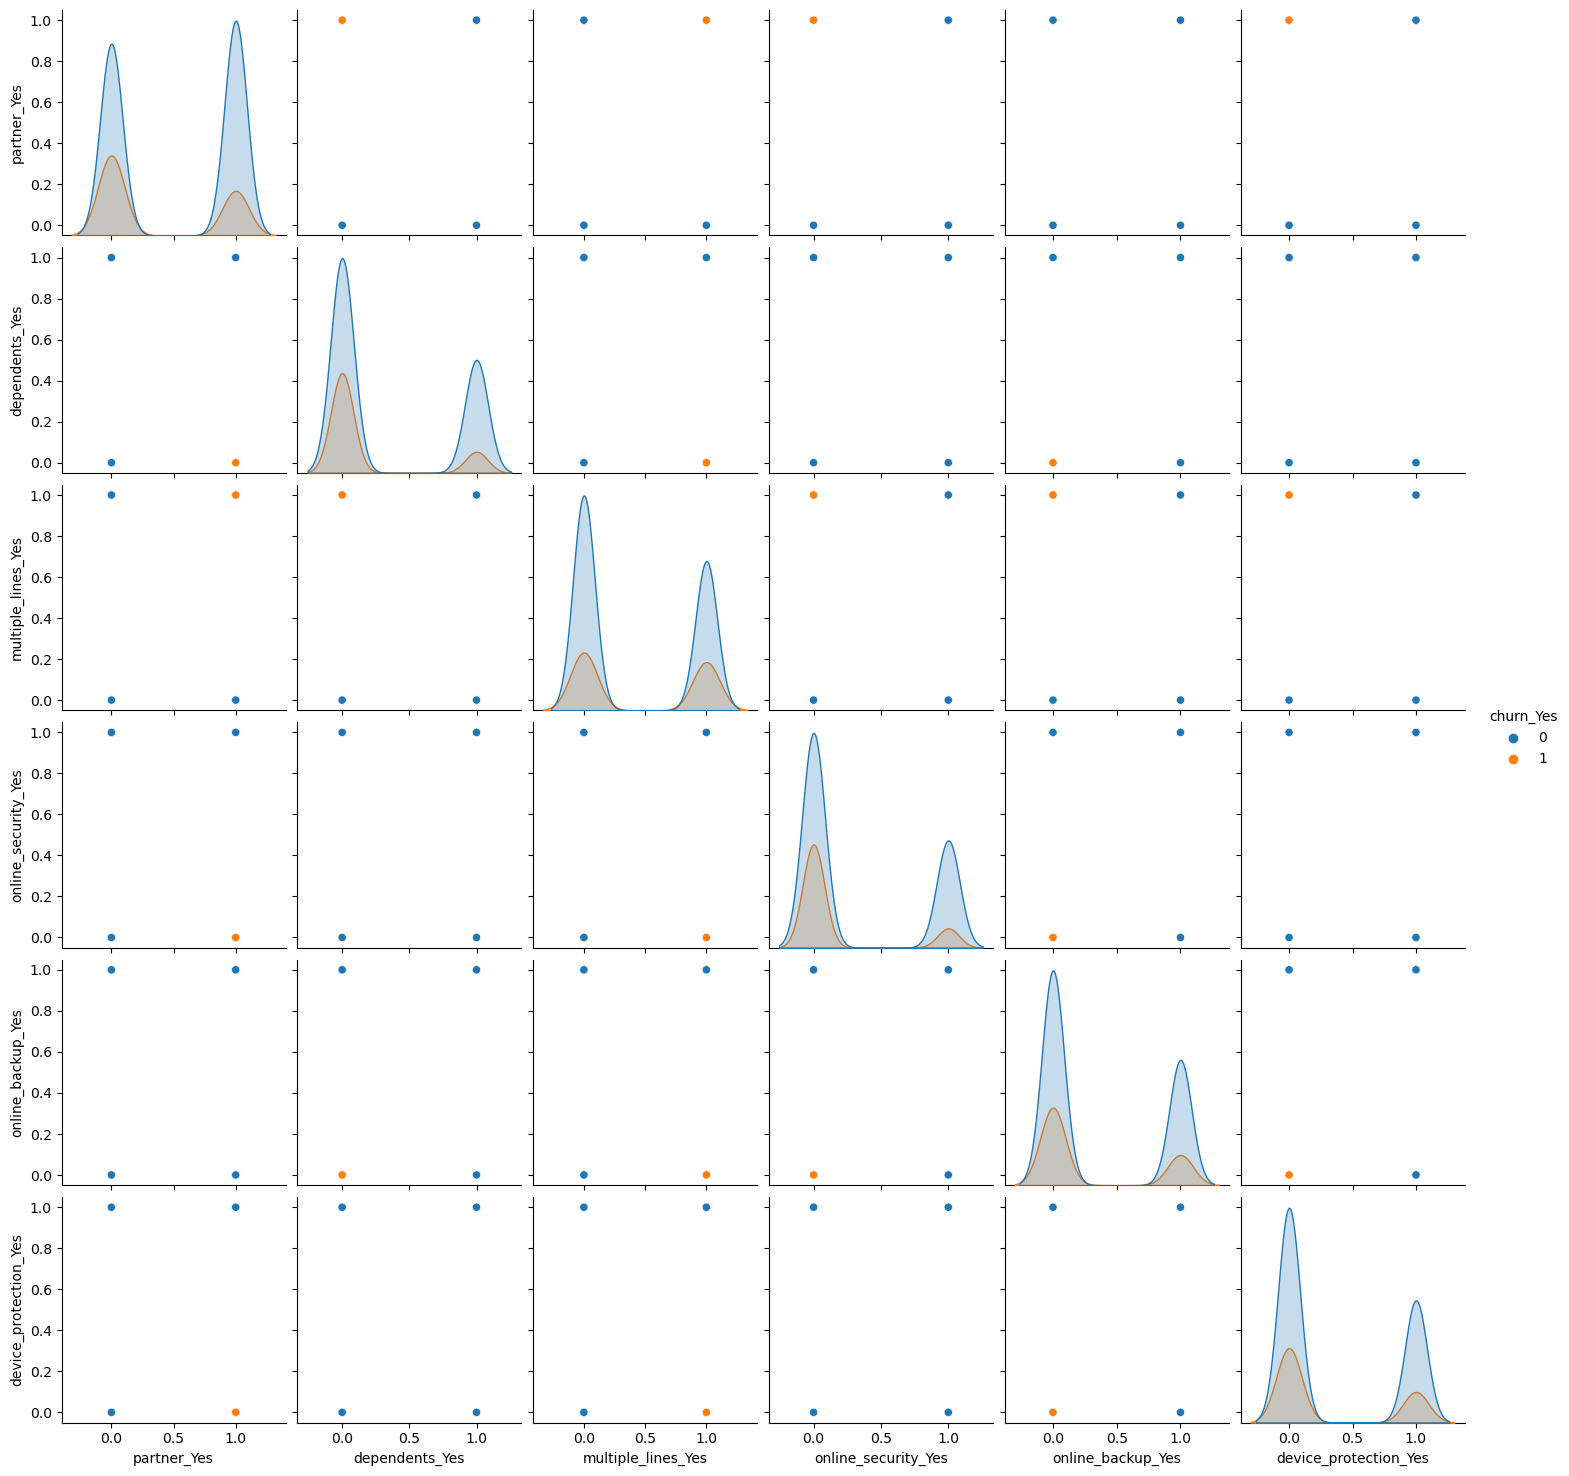

In [97]:
sns.pairplot(telco, x_vars = telco.columns[1:7], y_vars=telco.columns[1:7], hue='churn_Yes')

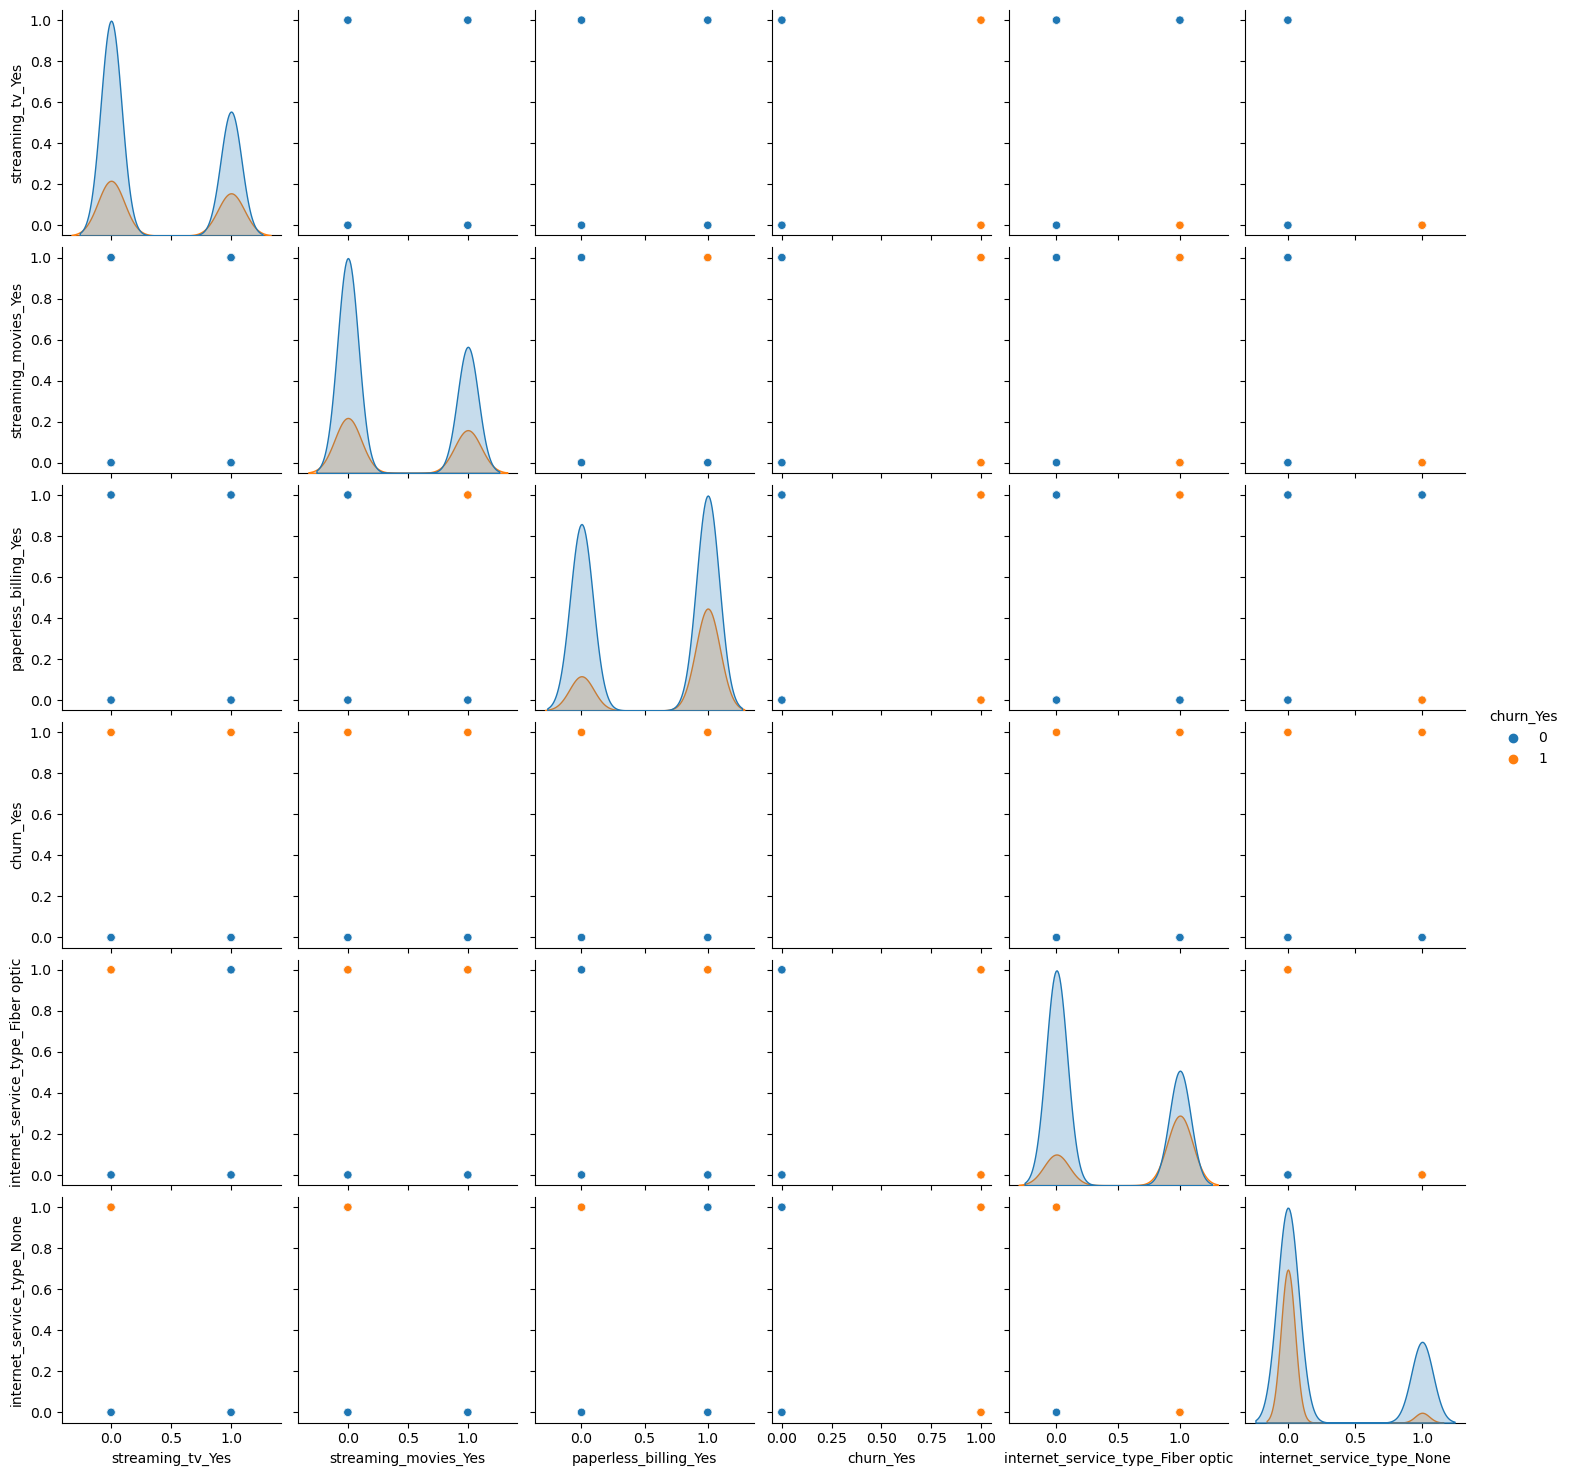

In [98]:
sns.pairplot(telco, x_vars = telco.columns[8:14], y_vars=telco.columns[8:14], hue='churn_Yes')

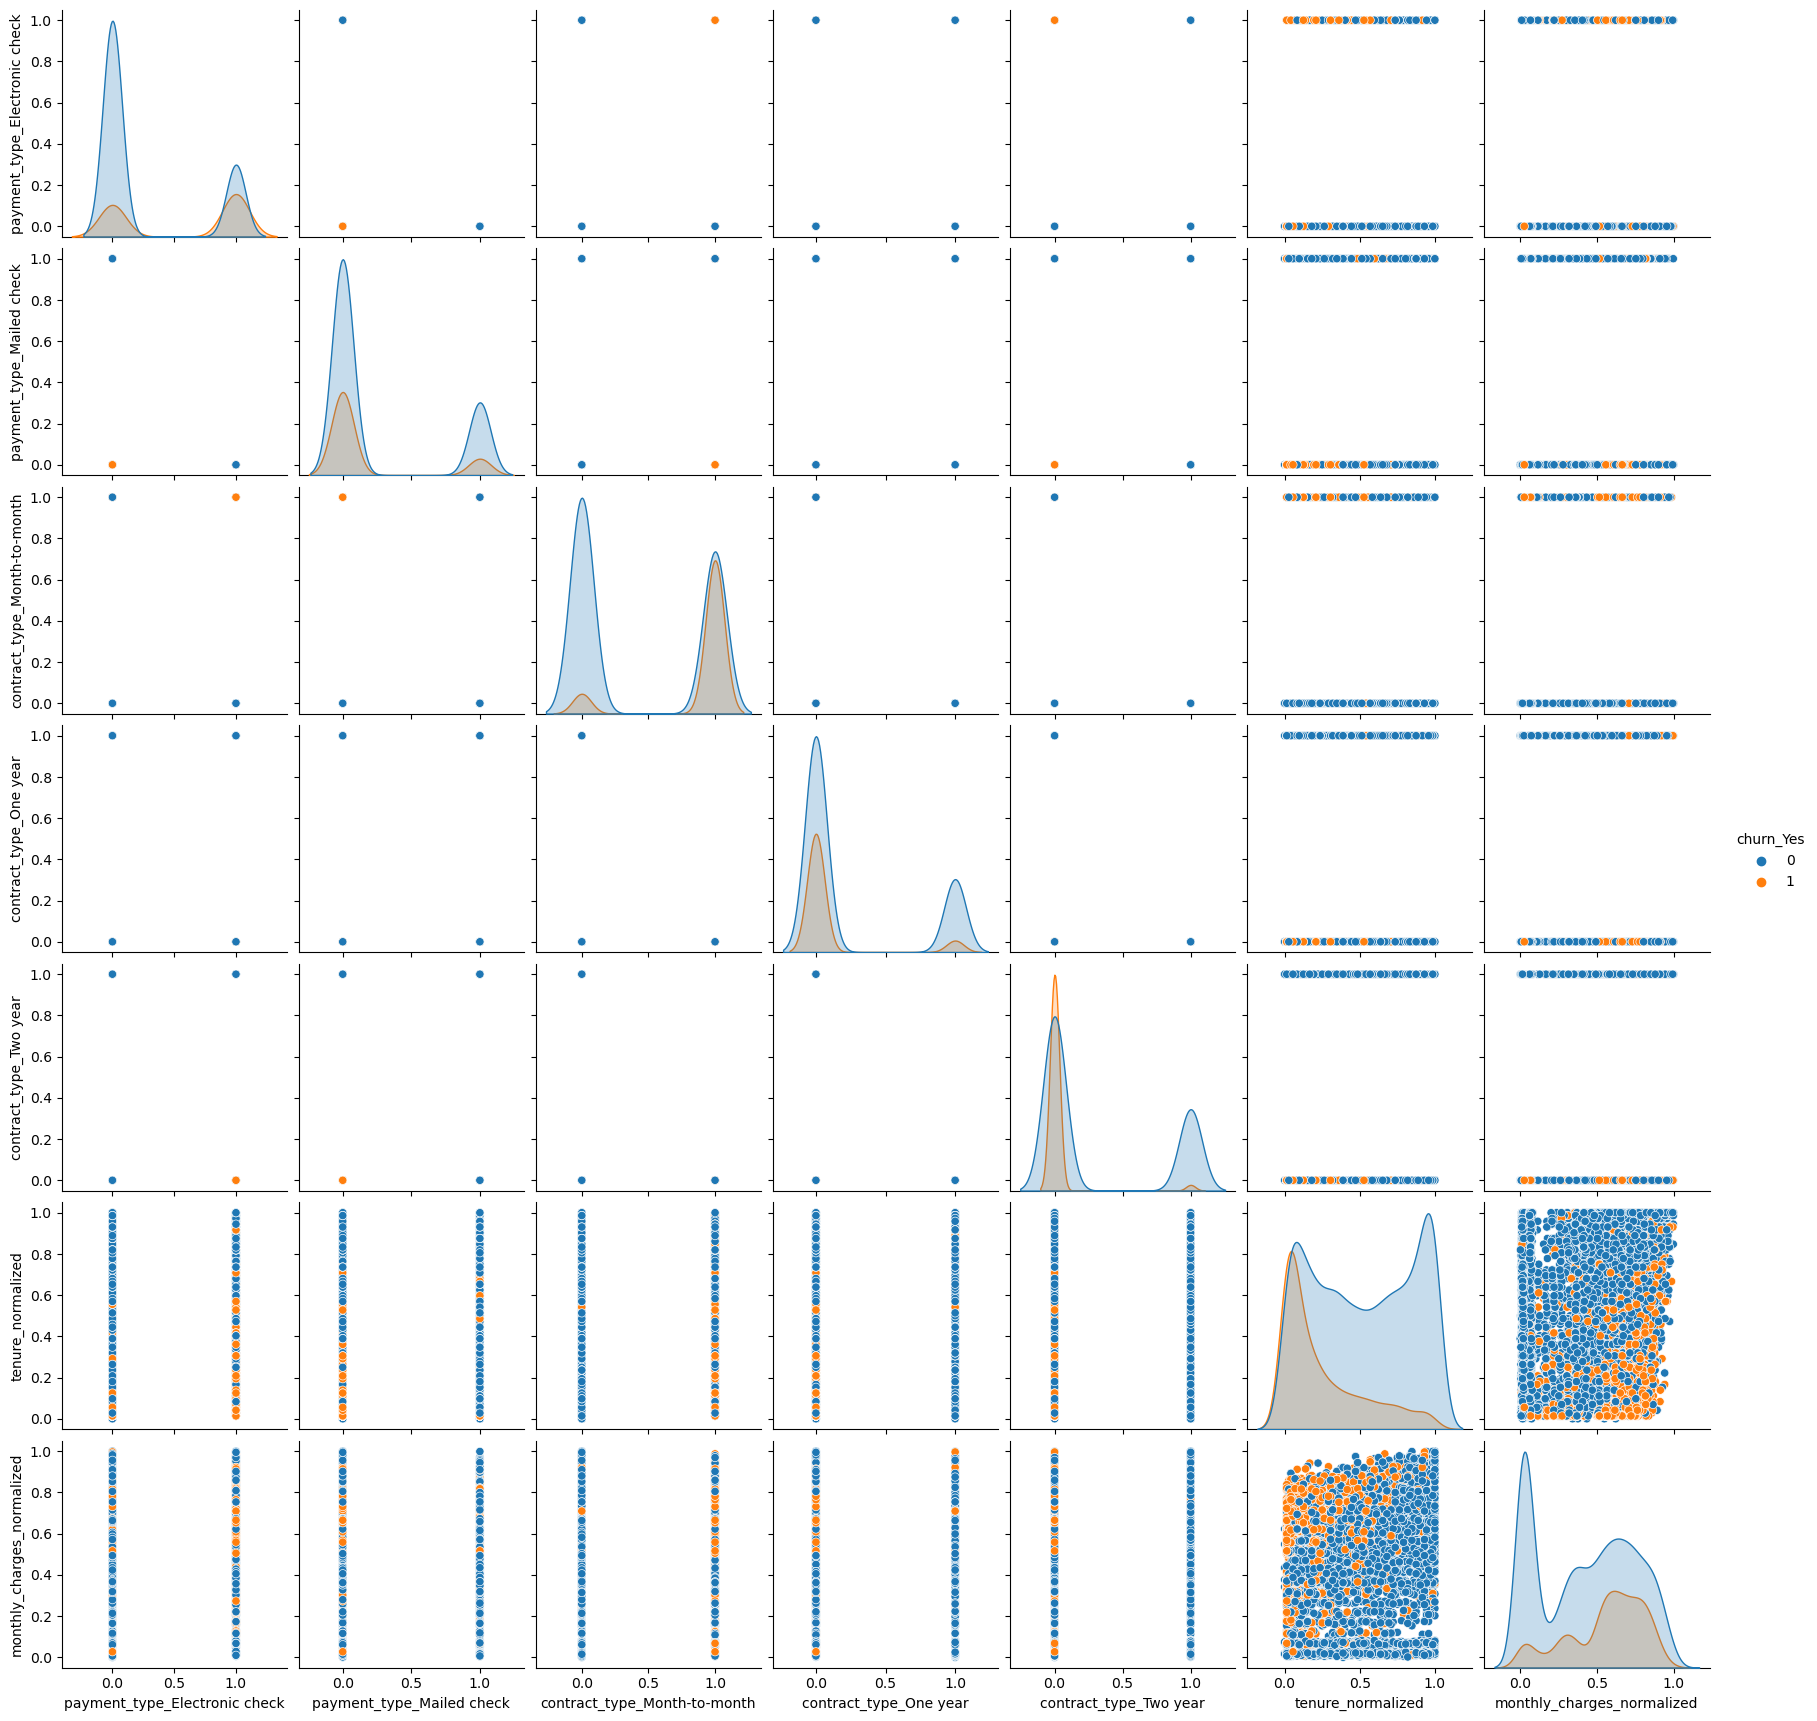

In [99]:
sns.pairplot(telco, x_vars = telco.columns[15:22], y_vars=telco.columns[15:22], hue='churn_Yes')

I performed this analysis before to see the dummy variable first column that was dropped.  Bringing this back should have no ulitmate impact on decision tree or random forest, outside of how the tree is labeled, but may have an impact on knn nearest neighbors especially since I am using manhattan coordinates.  Also it should add another layer to the logistic regression analysis which could theoretically help or hinder the result.  

In [130]:
telco_contract = telco[['contract_type_Month-to-month', 'contract_type_One year', 'contract_type_Two year', 'churn_Yes']]



In [131]:
month = pd.crosstab(telco['contract_type_Month-to-month'], telco['churn_Yes'])

In [132]:
chi2, p, degf, expected = stats.chi2_contingency(month)
chi2, p

(1153.9716611093477, 6.147585925549194e-253)

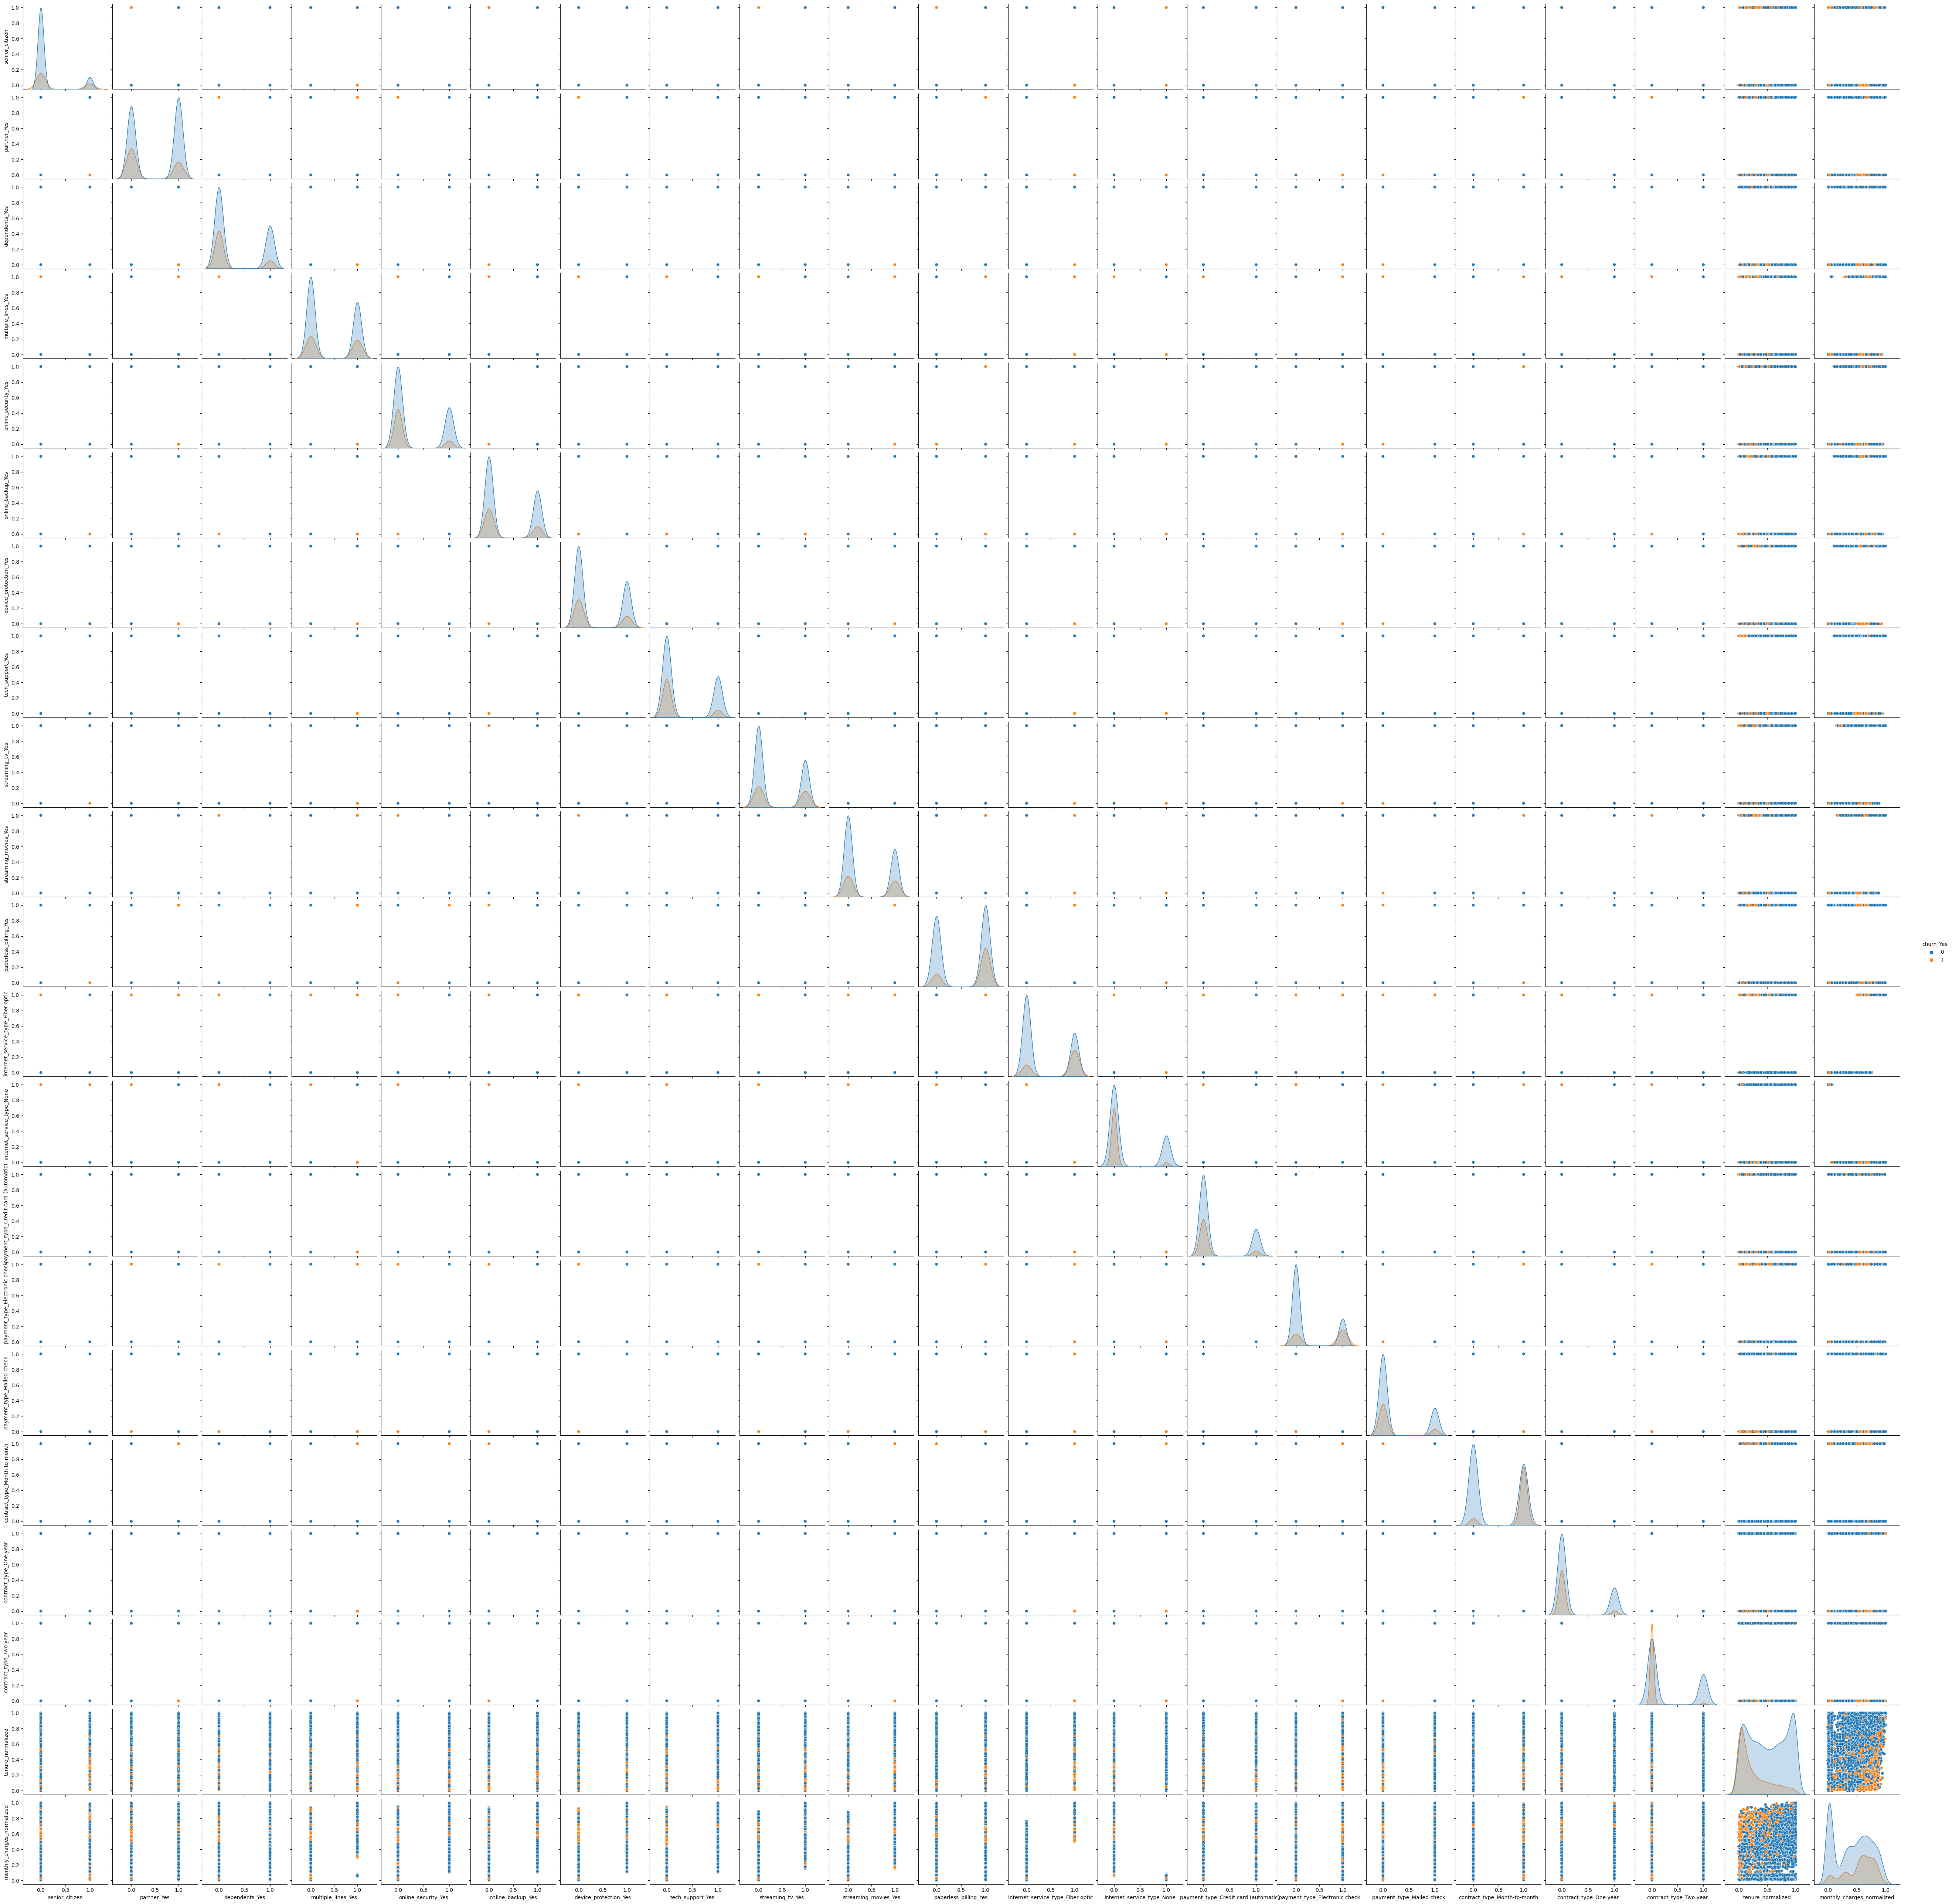

In [44]:
sns.pairplot(telco, hue='churn_Yes')

# Decision Tree

In [200]:
telco_string = telco.astype('str')
# telco = prepare.prep_telco()
# telco = telco.drop(columns=telco.select_dtypes(exclude='number').columns)
# telco = telco.astype('str')


In [201]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_string, 'churn_Yes')

In [202]:
X_train.shape, X_validate.shape, X_test.shape

((4225, 21), (1409, 21), (1409, 21))

In [203]:
y_train.shape, y_validate.shape, y_test.shape

((4225,), (1409,), (1409,))

['0' '0' '0' '0' '0']


array([[0.60572337, 0.39427663],
       [0.60572337, 0.39427663],
       [0.60572337, 0.39427663],
       [0.73333333, 0.26666667],
       [0.9877451 , 0.0122549 ]])

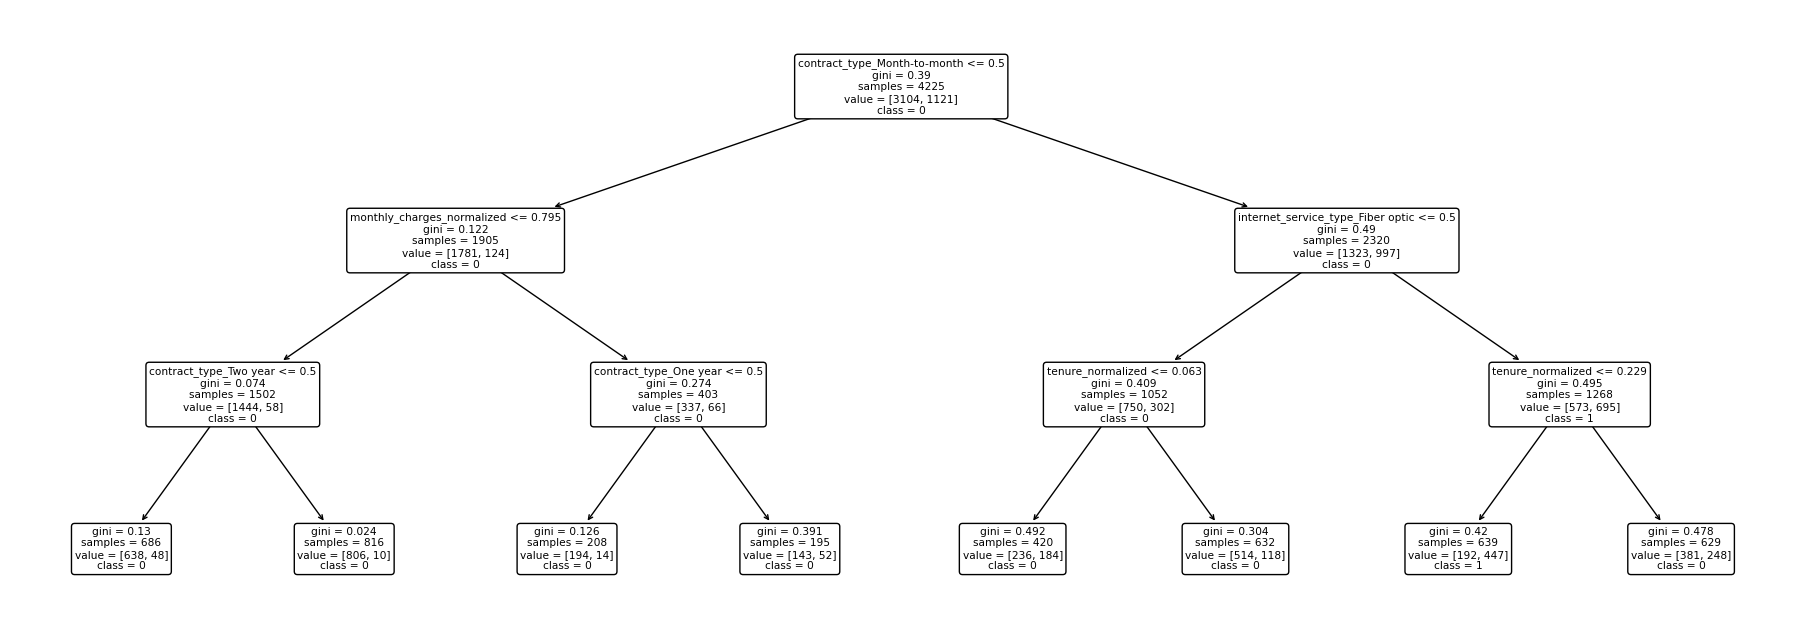

In [204]:
clf = DecisionTreeClassifier(max_depth=3, random_state=823)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(23, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, rounded=True)
y_pred = clf.predict(X_train)
print(y_pred[0:5])
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

In [205]:
print('Accuracy of Decision Tree classifier on training set: {:.8f}'
      .format(clf.score(X_train, y_train)))
print(confusion_matrix(y_train, y_pred))
print(y_train.value_counts())
labels = sorted(y_train.unique())
results = pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)
results

Accuracy of Decision Tree classifier on training set: 0.79502959
[[2912  192]
 [ 674  447]]
0    3104
1    1121
Name: churn_Yes, dtype: int64


,0,1
0,2912,192
1,674,447


In [206]:
results['0']['1']#/(results['0']['1']+results['1']['1'])  WHY THE HELL IS COLUMN AND ROW MIXED UP!

674

In [207]:
confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred)[1][1])

0.39875111507582517

In [208]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3104
           1       0.70      0.40      0.51      1121

    accuracy                           0.80      4225
   macro avg       0.76      0.67      0.69      4225
weighted avg       0.78      0.80      0.77      4225



In [209]:
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, random_state=823)
    clf = clf = clf.fit(X_train, y_train)
    #print(f'Accuracy of Decision Tree classifier on training set with depth {i}: {clf.score(X_train, y_train)})')
    #print(f'     Accuracy of Decision Tree classifier on validate set with depth {i}: {clf.score(X_validate, y_validate)})')
    print(f'Sensitivity of Decision Tree classifier on training set with depth {i}: {confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred)[1][1])}')

Sensitivity of Decision Tree classifier on training set with depth 1: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 2: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 3: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 4: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 5: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 6: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 7: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 8: 0.39875111507582517
Sensitivity of Decision Tree classifier on training set with depth 9: 0.39875111507582517


In [210]:
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, random_state=823)
    clf = clf = clf.fit(X_train, y_train)
    print(f'Accuracy Spread of Decision Tree classifier between train and validate with depth {i}: {clf.score(X_train, y_train) - clf.score(X_validate, y_validate)})')

Accuracy Spread of Decision Tree classifier between train and validate with depth 1: 0.00011103598590633812)
Accuracy Spread of Decision Tree classifier between train and validate with depth 2: 0.015502034679847676)
Accuracy Spread of Decision Tree classifier between train and validate with depth 3: 0.010075717807333184)
Accuracy Spread of Decision Tree classifier between train and validate with depth 4: 0.011970552786188637)
Accuracy Spread of Decision Tree classifier between train and validate with depth 5: 0.022620432469206864)
Accuracy Spread of Decision Tree classifier between train and validate with depth 6: 0.036108869020371914)
Accuracy Spread of Decision Tree classifier between train and validate with depth 7: 0.03777037724518206)
Accuracy Spread of Decision Tree classifier between train and validate with depth 8: 0.057648002486131)
Accuracy Spread of Decision Tree classifier between train and validate with depth 9: 0.09266986112102671)


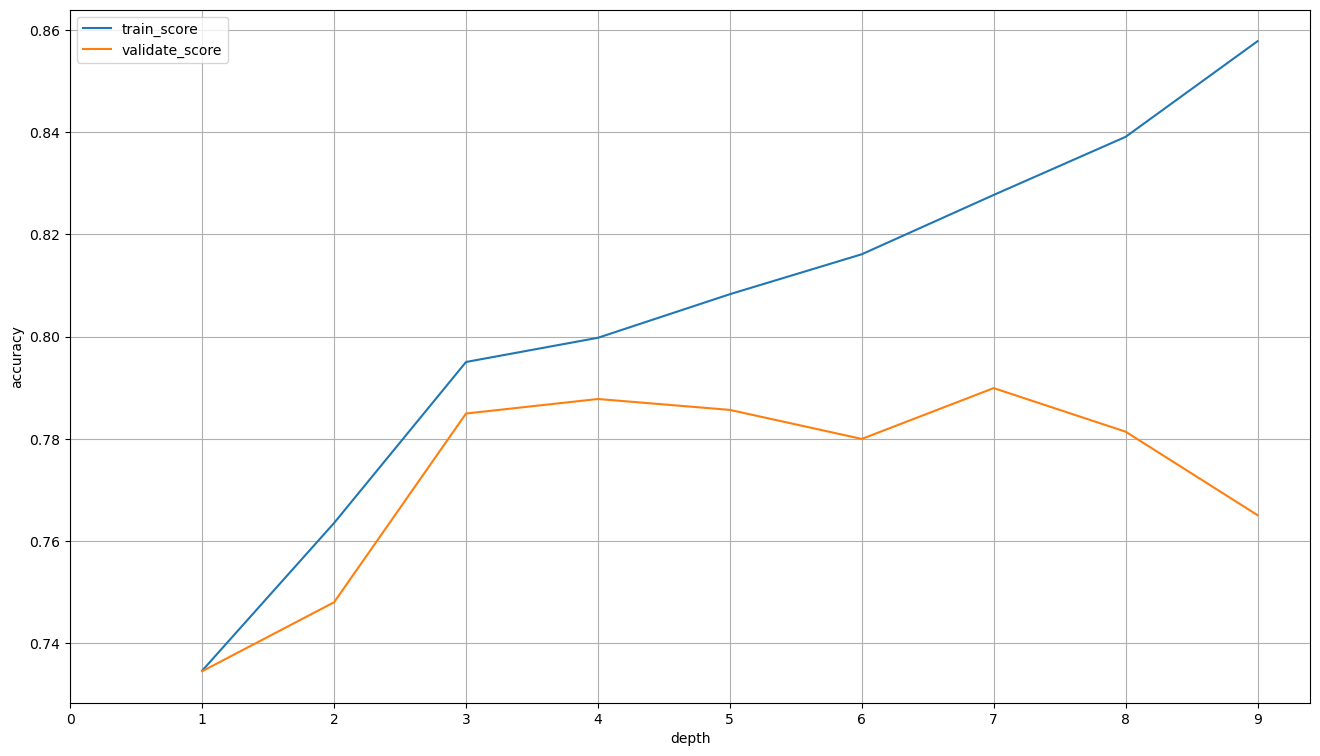

In [211]:
#FROM CLASS

metrics = []

# loop through different depths
for d in range(1,10):
    #MAKE the thing
    clf = DecisionTreeClassifier(max_depth=d, random_state=823)
    #FIT the thing
    clf = clf = clf.fit(X_train, y_train)
    #USE the thing
    train_score= clf.score(X_train, y_train)
    validate_score = clf.score(X_validate, y_validate)
    
    output = {
        "depth": d,
        "train_score": train_score,
        "validate_score": validate_score}
    
    metrics.append(output)
    
results = pd.DataFrame(metrics)

#PLOT the data
results.set_index('depth').plot(figsize=(16,9))
plt.ylabel('accuracy')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.show()

# Random Forrest

# KNN

In [264]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')

In [343]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=1)
knn5.fit(X_train, y_train)
y_pred5 = knn5.predict(X_train)
print(y_pred5[0:5])
y_pred_proba = knn5.predict_proba(X_train)
print(y_pred_proba[0:5])
knn5.classes_

[1 1 1 0 0]
[[0.2 0.8]
 [0.2 0.8]
 [0.4 0.6]
 [0.8 0.2]
 [1.  0. ]]


array([0, 1], dtype=uint8)

In [344]:
pd.crosstab(y_train, y_pred5)

col_0,0,1
churn_Yes,,
0,2797,307
1,397,724


In [347]:
confusion_matrix(y_train, y_pred5)[1][1]/(confusion_matrix(y_train, y_pred5)[1][1]+confusion_matrix(y_train, y_pred5)[1][0])

0.6458519179304193

In [337]:
telco.describe()

,senior_citizen,partner_Yes,dependents_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,...,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,tenure_normalized,monthly_charges_normalized
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,...,0.439585,0.216669,0.216101,0.335794,0.228880,0.550192,0.209144,0.240664,0.449599,0.462803
std,0.368612,0.499748,0.458110,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,...,0.496372,0.412004,0.411613,0.472301,0.420141,0.497510,0.406726,0.427517,0.341104,0.299403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.171642
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.402778,0.518408
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.763889,0.712438
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [338]:
y_pred = knn5.predict(X_train)
print(y_pred[0:5])
y_pred_proba = knn5.predict_proba(X_train)
y_pred_proba[0:5]
print(confusion_matrix(y_train, y_pred))
y_val = knn5.predict(X_validate)
y_val_proba = knn5.predict_proba(X_validate)

[1 1 1 0 0]
[[2797  307]
 [ 397  724]]


In [339]:
print(f'Sensitivity of Decision Tree classifier on training set with depth {i}: {confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred)[1][1])}')

Sensitivity of Decision Tree classifier on training set with depth 19: 0.6458519179304193


In [340]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3104
           1       0.70      0.65      0.67      1121

    accuracy                           0.83      4225
   macro avg       0.79      0.77      0.78      4225
weighted avg       0.83      0.83      0.83      4225



In [341]:
print(confusion_matrix(y_validate, y_val))

[[886 149]
 [175 199]]


In [359]:
model_set = []
model_accuracies = {}

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p=1)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)
    
    y_val = knn.predict(X_validate)
    y_val_proba = knn.predict_proba(X_validate)
    
    st = round(confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred))[1][1], 5)
    sv = round(confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val))[1][1], 5)
    model_set.append(knn)
    model_accuracies[f'{i} neighbors'] = {
        'train_score' : round(knn.score(X_train, y_train), 5),
        'validate_score' : round(knn.score(X_validate, y_validate), 5),
        'Sensitivity_train' : st,
        'Sensitivity_validate' : sv,
        'Sensitivity_difference' : (st-sv),
        'Just_for_analysis_TP' : (confusion_matrix(y_train, y_pred)[0][0]/3104), 
        'Just_for_analysis_TP_val' : (confusion_matrix(y_validate, y_val)[0][0]/1121)
    }

In [360]:
model_set

[KNeighborsClassifier(n_neighbors=1, p=1),
 KNeighborsClassifier(n_neighbors=2, p=1),
 KNeighborsClassifier(n_neighbors=3, p=1),
 KNeighborsClassifier(n_neighbors=4, p=1),
 KNeighborsClassifier(p=1),
 KNeighborsClassifier(n_neighbors=6, p=1),
 KNeighborsClassifier(n_neighbors=7, p=1),
 KNeighborsClassifier(n_neighbors=8, p=1),
 KNeighborsClassifier(n_neighbors=9, p=1),
 KNeighborsClassifier(n_neighbors=10, p=1),
 KNeighborsClassifier(n_neighbors=11, p=1),
 KNeighborsClassifier(n_neighbors=12, p=1),
 KNeighborsClassifier(n_neighbors=13, p=1),
 KNeighborsClassifier(n_neighbors=14, p=1),
 KNeighborsClassifier(n_neighbors=15, p=1),
 KNeighborsClassifier(n_neighbors=16, p=1),
 KNeighborsClassifier(n_neighbors=17, p=1),
 KNeighborsClassifier(n_neighbors=18, p=1),
 KNeighborsClassifier(n_neighbors=19, p=1)]

In [361]:
model_accuracies

{'1 neighbors': {'train_score': 0.99669,
  'validate_score': 0.72818,
  'Sensitivity_train': 0.99554,
  'Sensitivity_validate': 0.49733,
  'Sensitivity_difference': 0.49821,
  'Just_for_analysis_TP': 0.9971005154639175,
  'Just_for_analysis_TP_val': 0.7493309545049064},
 '2 neighbors': {'train_score': 0.86959,
  'validate_score': 0.76579,
  'Sensitivity_train': 0.50847,
  'Sensitivity_validate': 0.34225,
  'Sensitivity_difference': 0.16621999999999998,
  'Just_for_analysis_TP': 1.0,
  'Just_for_analysis_TP_val': 0.848349687778769},
 '3 neighbors': {'train_score': 0.8632,
  'validate_score': 0.75869,
  'Sensitivity_train': 0.70562,
  'Sensitivity_validate': 0.54813,
  'Sensitivity_difference': 0.15749000000000002,
  'Just_for_analysis_TP': 0.9201030927835051,
  'Just_for_analysis_TP_val': 0.7707404103479036},
 '4 neighbors': {'train_score': 0.83811,
  'validate_score': 0.77076,
  'Sensitivity_train': 0.49955,
  'Sensitivity_validate': 0.39572,
  'Sensitivity_difference': 0.1038299999999

In [362]:
pd.DataFrame(model_accuracies).T

,train_score,validate_score,Sensitivity_train,Sensitivity_validate,Sensitivity_difference,Just_for_analysis_TP,Just_for_analysis_TP_val
1 neighbors,0.99669,0.72818,0.99554,0.49733,0.49821,0.997101,0.749331
2 neighbors,0.86959,0.76579,0.50847,0.34225,0.16622,1.000000,0.848350
3 neighbors,0.86320,0.75869,0.70562,0.54813,0.15749,0.920103,0.770740
4 neighbors,0.83811,0.77076,0.49955,0.39572,0.10383,0.960374,0.836753
5 neighbors,0.83337,0.77005,0.64585,0.53209,0.11376,0.901095,0.790366
6 neighbors,0.82225,0.78282,0.50758,0.44118,0.06640,0.935889,0.836753
7 neighbors,0.82154,0.78070,0.61017,0.53209,0.07808,0.897874,0.803747
8 neighbors,0.82154,0.78424,0.54416,0.48663,0.05753,0.921714,0.823372
9 neighbors,0.81420,0.78211,0.60393,0.57487,0.02906,0.890142,0.791258
10 neighbors,0.81491,0.78850,0.54148,0.51604,0.02544,0.913660,0.818912


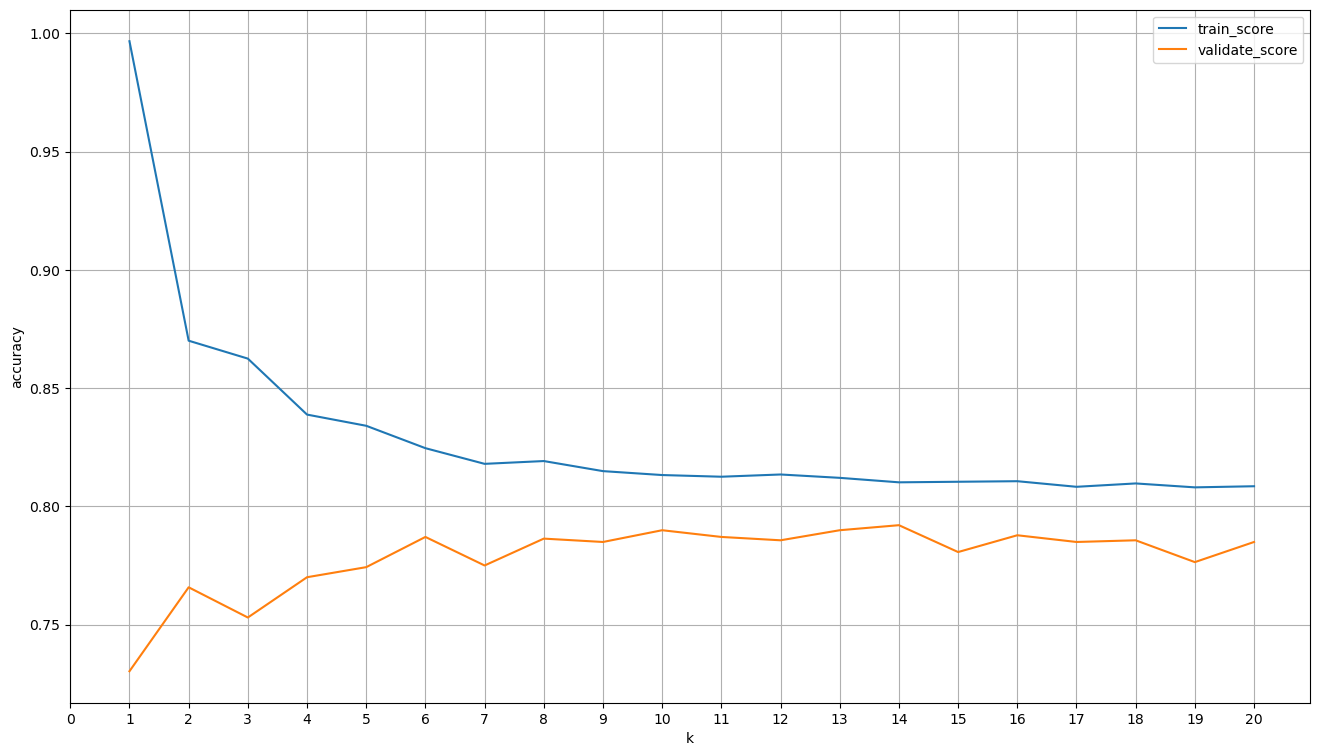

In [202]:
metrics = []

# loop through different values of k
for k in range(1,21):
    #MAKE the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    #FIT the thing
    knn.fit(X_train, y_train)
    #USE the thing
    train_score= knn.score(X_train, y_train)
    validate_score = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_score": train_score,
        "validate_score": validate_score}
    
    metrics.append(output)
    
results = pd.DataFrame(metrics)

#PLOT the data
results.set_index('k').plot(figsize=(16,9))
plt.ylabel('accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

In [60]:
#telco_knn = prepare.prep_telco_alternative()
telco_knn = telco
telco_knn

,senior_citizen,partner_Yes,dependents_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,...,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,tenure_normalized,monthly_charges_normalized
0,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,1,0,1,0,0.125000,0.471144
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0.125000,0.414428
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0.055556,0.553731
3,1,1,0,0,0,1,1,0,1,1,...,1,0,0,1,0,1,0,0,0.180556,0.793532
4,1,1,0,0,0,0,0,1,1,0,...,1,0,0,0,1,1,0,0,0.041667,0.653234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0.180556,0.367164
7039,0,1,0,1,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0.305556,0.665174
7040,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0.027778,0.318905
7041,0,1,1,0,1,0,1,1,0,1,...,0,0,0,0,1,0,0,1,0.930556,0.493532


In [61]:
telco_knn.columns

Index(['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'churn_Yes',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check', 'contract_type_Month-to-month',
       'contract_type_One year', 'contract_type_Two year', 'tenure_normalized',
       'monthly_charges_normalized'],
      dtype='object')

In [62]:
telco_knn['senior_citizen'] = telco_knn['senior_citizen'].replace([0,1], [1,0])
telco_knn['partner_Yes'] = telco_knn['partner_Yes'].replace([0,1], [1,0])
telco_knn['dependents_Yes'] = telco_knn['dependents_Yes'].replace([0,1], [1,0])
telco_knn['multiple_lines_Yes'] = telco_knn['multiple_lines_Yes'].replace([0,1], [1,0])
telco_knn['online_security_Yes'] = telco_knn['online_security_Yes'].replace([0,1], [1,0])
telco_knn['online_backup_Yes'] = telco_knn['online_backup_Yes'].replace([0,1], [1,0])
telco_knn['device_protection_Yes'] = telco_knn['device_protection_Yes'].replace([0,1], [1,0])
telco_knn['tech_support_Yes'] = telco_knn['tech_support_Yes'].replace([0,1], [1,0])
telco_knn['internet_service_type_Fiber optic'] = telco_knn['internet_service_type_Fiber optic'].replace([0,1], [1,0])
telco_knn['internet_service_type_None'] = telco_knn['internet_service_type_None'].replace([0,1], [1,0])
telco_knn['payment_type_Mailed check'] = telco_knn['payment_type_Mailed check'].replace([0,1], [1,0])
telco_knn['contract_type_One year'] = telco_knn['contract_type_One year'].replace([0,1], [1,0])
telco_knn['contract_type_Two year'] = telco_knn['contract_type_Two year'].replace([0,1], [1,0])
telco_knn['tenure_normalized'] = telco_knn['tenure_normalized'].replace([0,1], [1,0])

In [71]:
telco_knn = telco_knn.drop(columns=['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'payment_type_Credit card (automatic)', 'payment_type_Mailed check'])

In [72]:
telco_knn = telco_knn.drop(columns=['streaming_tv_Yes', 'streaming_movies_Yes', 'monthly_charges_normalized'])

In [73]:
telco_knn

,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Electronic check,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,tenure_normalized
0,1,0,1,1,0,0,0,1,0.125000
1,0,0,1,1,0,1,1,1,0.125000
2,1,1,0,1,1,1,1,1,0.055556
3,1,1,0,1,1,1,1,1,0.180556
4,1,1,0,1,0,1,1,1,0.041667
...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,0,0,0,1,0.180556
7039,1,1,0,1,1,1,1,1,0.305556
7040,1,0,1,1,0,1,1,1,0.027778
7041,0,0,1,1,0,0,1,0,0.930556


In [102]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_knn, 'churn_Yes')

In [75]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn5.fit(X_train, y_train)
y_pred5 = knn5.predict(X_train)
print(y_pred5[0:5])
y_pred_proba = knn5.predict_proba(X_train)
print(y_pred_proba[0:5])
knn5.classes_

[0 0 1 0 0]
[[0.8  0.2 ]
 [1.   0.  ]
 [0.25 0.75]
 [1.   0.  ]
 [1.   0.  ]]


array([0, 1], dtype=uint8)

In [103]:
model_set = []
model_accuracies = {}

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p=1)
    knn.fit(X_train, y_train)
    
    model_set.append(knn)
    model_accuracies[f'{i} neighbors'] = {
        'train_score' : round(knn.score(X_train, y_train), 5),
        'validate_score' : round(knn.score(X_validate, y_validate), 5)
    }

In [106]:
model_set

[KNeighborsClassifier(n_neighbors=1, p=1),
 KNeighborsClassifier(n_neighbors=2, p=1),
 KNeighborsClassifier(n_neighbors=3, p=1),
 KNeighborsClassifier(n_neighbors=4, p=1),
 KNeighborsClassifier(p=1),
 KNeighborsClassifier(n_neighbors=6, p=1),
 KNeighborsClassifier(n_neighbors=7, p=1),
 KNeighborsClassifier(n_neighbors=8, p=1),
 KNeighborsClassifier(n_neighbors=9, p=1),
 KNeighborsClassifier(n_neighbors=10, p=1),
 KNeighborsClassifier(n_neighbors=11, p=1),
 KNeighborsClassifier(n_neighbors=12, p=1),
 KNeighborsClassifier(n_neighbors=13, p=1),
 KNeighborsClassifier(n_neighbors=14, p=1),
 KNeighborsClassifier(n_neighbors=15, p=1),
 KNeighborsClassifier(n_neighbors=16, p=1),
 KNeighborsClassifier(n_neighbors=17, p=1),
 KNeighborsClassifier(n_neighbors=18, p=1),
 KNeighborsClassifier(n_neighbors=19, p=1)]

In [105]:
model_accuracies

{'1 neighbors': {'train_score': 0.78793, 'validate_score': 0.73669},
 '2 neighbors': {'train_score': 0.77633, 'validate_score': 0.74379},
 '3 neighbors': {'train_score': 0.80308, 'validate_score': 0.77005},
 '4 neighbors': {'train_score': 0.80237, 'validate_score': 0.78282},
 '5 neighbors': {'train_score': 0.81657, 'validate_score': 0.7807},
 '6 neighbors': {'train_score': 0.81136, 'validate_score': 0.77573},
 '7 neighbors': {'train_score': 0.81491, 'validate_score': 0.77644},
 '8 neighbors': {'train_score': 0.81231, 'validate_score': 0.78211},
 '9 neighbors': {'train_score': 0.8168, 'validate_score': 0.77857},
 '10 neighbors': {'train_score': 0.81491, 'validate_score': 0.7807},
 '11 neighbors': {'train_score': 0.81704, 'validate_score': 0.76934},
 '12 neighbors': {'train_score': 0.81396, 'validate_score': 0.77218},
 '13 neighbors': {'train_score': 0.81278, 'validate_score': 0.77644},
 '14 neighbors': {'train_score': 0.81278, 'validate_score': 0.78353},
 '15 neighbors': {'train_score':

In [ ]:
df['column name'] = df['column name'].replace(['1st old value', '2nd old value', ...], ['1st new value', '2nd new value', ...])